# **House Prices Regression Predicction Model**
## **Introduction**
### Dataset Overview
The data model study below is based on Kaggle open dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

This is the US Housing dataset in Ames, Lowa. It cotains 79 features related to house information such as OverallQual, LotArea, YearBuilt and quality Condition.

### Objective
The goal is to predict the housing price by training a regression model with the provided data and explain what are the key factors affecting the house price.

### Model Training Flow
1. Data Cleaning & Exploration
2. Data Transformation
3. Model Selection
4. Base Model Training
5. Feature Engineering and Model Finetune
6. Conclusion

## **Import Libaries**
Common libraries for data plotting and model training.
Optuna library is used for model hyperparameter optimization.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rs= RobustScaler()
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import Ridge as RG
from sklearn import linear_model
Lasso = linear_model.Lasso(alpha=0.01)
Lars = linear_model.Lars()
LassoLars=linear_model.LassoLars(alpha=0.01)
from xgboost import XGBRegressor as XGBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR

import optuna

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
#from sklearn import metrics
#from sklearn.model_selection import ShuffleSplit
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import precision_score
#from RegscorePy import *
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import shap

#from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


## **1. Data Cleaning & Exploration**
### **Section Summary:**

### **Section Highlights:**


In [527]:
df=pd.read_csv("train.csv")

Quick check has found 'NaN' in train data

In [528]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0000,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0000,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0000,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0000,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


High level understanding on data. The target response is 'SalePrice'. It has positive skew and high outlier price.

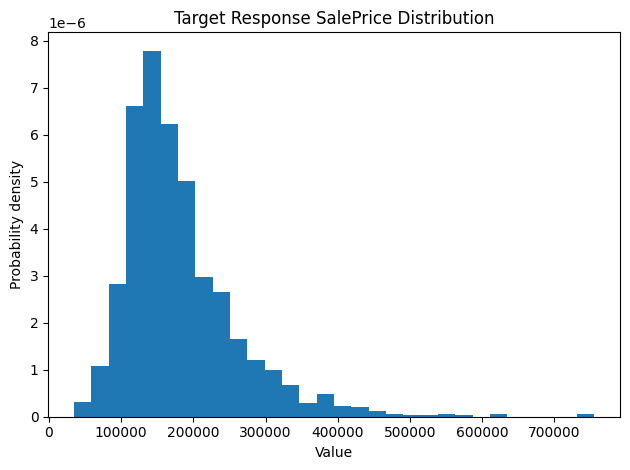

In [529]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df['SalePrice'], 30, density=True)
ax.set_xlabel('Value')
ax.set_ylabel('Probability density')
ax.set_title('Target Response SalePrice Distribution')
fig.tight_layout()
plt.show()

In [530]:
df['SalePrice'].describe()

count     1460.0000
mean    180921.1959
std      79442.5029
min      34900.0000
25%     129975.0000
50%     163000.0000
75%     214000.0000
max     755000.0000
Name: SalePrice, dtype: float64

No duplication.

In [531]:
df.duplicated().sum()

0

At least has two unique values.

In [532]:
df.nunique().sort_values(ascending=False)

Id            1460
LotArea       1073
GrLivArea      861
BsmtUnfSF      780
1stFlrSF       753
              ... 
HalfBath         3
Street           2
CentralAir       2
Utilities        2
Alley            2
Length: 81, dtype: int64

There are many features having high missing values.

In [533]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

Create function to investigate the missing values.

In [534]:
def missing_feat(df):
    null_col=pd.DataFrame(columns=['Feature','Total Transaction','Transaction with Missing Value','Missing %'])
    null_col_index=0
    for i in df.isnull().sum().sort_values(ascending=False).index:
        null_col.loc[null_col_index]=[i,
                                    len(df),
                                    df[i].isnull().sum(),
                                    float(df[i].isnull().sum()/len(df))*100,
                                    ]
        null_col_index=null_col_index+1

    print('Features with missing values')
    display(null_col[null_col['Missing %']>0])

    fig = px.ecdf(null_col, x="Missing %",marginal="histogram",title="Cumulative Distribution of Feature(column) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Feature Density',
                        )  

    fig.show()

    return null_col

About 25% features contain missing feature, from ~5% to ~95% missing.

In [535]:
feat_missing_df=missing_feat(df)

Features with missing values


,Feature,Total Transaction,Transaction with Missing Value,Missing %
0,PoolQC,1460,1453,99.5205
1,MiscFeature,1460,1406,96.3014
2,Alley,1460,1369,93.7671
3,Fence,1460,1179,80.7534
4,MasVnrType,1460,872,59.7260
5,FireplaceQu,1460,690,47.2603
6,LotFrontage,1460,259,17.7397
7,GarageYrBlt,1460,81,5.5479
8,GarageCond,1460,81,5.5479
9,GarageType,1460,81,5.5479


There are features with almost 90% missing values! However the data description file provided by dataset explain certain housing feature are not available, hence it is NaN in the dataset. For example, 'PoolQC' is the quality assessment for the pool:

In [536]:
df['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

There is also feature related to pool area 'PoolArea'. For 'PoolArea' more than 0 (i.e. the house has pool), there are no missing 'PoolQC', in another words, the 'PoolQC' is available only for house with pool. 'Ex' is Excellent, 'Fa' is Fair, etc...

In [537]:
df[['PoolArea','PoolQC']][df['PoolArea']>0]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd


Similarly for 'MiscFeature', it is miscellaneous feature which is not covered in other categories. It should be kept as well. 'MiscVa' is the value of the 'MiscFeature'.

In [538]:
df['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [539]:
df[['MiscVal','MiscFeature']][df['MiscVal']>0]

,MiscVal,MiscFeature
5,700,Shed
7,350,Shed
16,700,Shed
17,500,Shed
51,400,Shed
84,700,Shed
95,480,Shed
98,400,Shed
99,400,Shed
106,450,Shed


Similarly,
1. 'Alley': Type of alley access
2. 'Fence': Fence quality
3. 'MasVnrType': Masonry veneer type; 'MasVnrArea': Masonry veneer area in square feet
4. 'FireplaceQu': Fireplace quality; 'Fireplaces': Number of fireplaces
5. 'LotFrontage': Linear feet of street connected to property
6. 'GarageYrBlt': Year garage was built; 'GarageType': Garage location; 'GarageCond': Garage condition

In conclusion, these are valid data and do not have to remove them. Data transformation will be applied on the NaN values before model training.

In [540]:
#Not used
def missing_row(df):
    null_row=pd.DataFrame(columns=['Row ID','Total Feature','Feature With Missing Value','Missing %'])
    null_row_index=0
    for i in range(len(df)):
        if df.iloc[i].isnull().sum()>0:
            null_row.loc[null_row_index]=[df['Id'][i],
                                        len(df.columns),
                                        df.iloc[i].isnull().sum(),
                                        float(df.iloc[i].isnull().sum()/len(df.columns))*100,
            ]
            null_row_index=null_row_index+1

    print('Transaction with missing feature value')
    display(null_row.sort_values(ascending=False,by='Missing %'))

    fig = px.ecdf(null_row, x="Missing %",marginal="histogram",title="Cumulative Distribution of Transaction (row ID) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Row Density',
                        )
            
    fig.show()

    return null_row

Moving to data exploration. First thing to find which are numeric and categorical features:

Drop 'Id' and 'SalePrice' befire feature transformation

In [541]:
feat_df=df.drop(['Id','SalePrice'],axis=1)

In [542]:
cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
cat_feat.sort_values()

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [543]:
num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
num_feat.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

'MSSubClass' is int type but it is supposed to be categorical, hence it is grouped under cat_feat
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [544]:
num_feat=num_feat.drop('MSSubClass')
num_feat

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [545]:
cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
cat_feat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

Create conversion function to convert the quality with ordinary label.
1. Ex	Excellent     ->5
2. Gd	Good   ->4
3.TA	Typical - slight dampness allowed  ->3
4. Fa	Fair - dampness or some cracking or settling     ->2
5. Po	Poor - Severe cracking, settling, or wetness     ->1
6. NA	No Basement   ->0

For numerical feature, quick check on the correlation with the target response 'SalePrice':

In [546]:
#interactive corrrelation heatmap for numberic feat.Roughly check the correlation with target SalePrice, and their intercorrelation
def corr_map(df,included_col,target_response):
    corr_df=df
    for i in corr_df.columns:
        if i not in included_col:
            corr_df=corr_df.drop([i],axis=1)
    
    corr_df=pd.concat([corr_df,df[target_response]],axis=1)

    print('Correlation score with SalePrice:')
    display(corr_df.corr()['SalePrice'].sort_values(ascending=False))
    fig = px.imshow(corr_df.corr(),
                    width=1200,
                    height=800,
                    #text_auto=True,
                    title='Correlation Heatmap'
                    )
    fig.show()
    return corr_df.corr()

### Data visualization
'OverallQual', 'GrLivingArea' are the top 2 numerical features with more than +0.7 corretion score

In [547]:
num_feat_corr=corr_map(df,num_feat,'SalePrice')

Correlation score with SalePrice:


SalePrice        1.0000
OverallQual      0.7910
GrLivArea        0.7086
GarageCars       0.6404
GarageArea       0.6234
TotalBsmtSF      0.6136
1stFlrSF         0.6059
FullBath         0.5607
TotRmsAbvGrd     0.5337
YearBuilt        0.5229
YearRemodAdd     0.5071
GarageYrBlt      0.4864
MasVnrArea       0.4775
Fireplaces       0.4669
BsmtFinSF1       0.3864
LotFrontage      0.3518
WoodDeckSF       0.3244
2ndFlrSF         0.3193
OpenPorchSF      0.3159
HalfBath         0.2841
LotArea          0.2638
BsmtFullBath     0.2271
BsmtUnfSF        0.2145
BedroomAbvGr     0.1682
ScreenPorch      0.1114
PoolArea         0.0924
MoSold           0.0464
3SsnPorch        0.0446
BsmtFinSF2      -0.0114
BsmtHalfBath    -0.0168
MiscVal         -0.0212
LowQualFinSF    -0.0256
YrSold          -0.0289
OverallCond     -0.0779
EnclosedPorch   -0.1286
KitchenAbvGr    -0.1359
Name: SalePrice, dtype: float64

'OverallCond' is rating of overall material and finishing condition (1 to 10), while 'GrLivArea' is 'above grade (ground) living area square feet'. In scatter plot below, Y axis is the 'SalePrice', X axis is the 'GrLivArea' and the color intensity follow the 'OverallCond'. It is clear that with larger above grade living area and better overall condition, the sale price is higher.

In [640]:
fig = px.scatter(df, x='OverallQual',y='SalePrice',color='GrLivArea')
fig.show()

The t-test function select a pair of subgroups from categorical feature to perform ANOVA test baseed on the target response 'SalePrice'. For categorical features, t-test will be used to see if any abnormal distinction is found.

In [549]:
#convert feat subgroup into series for t-test
def series_dict(df1):
    a={}
    for i in df1.index:
        if df1.iloc[i][0] not in a:
            a.update({df1.iloc[i][0]:[df1.iloc[i][1]]})
        if df1.iloc[i][0] in a:
            a[df1.iloc[i][0]].append(df1.iloc[i][1])
    return a

#t-test for the feature value from series
def series_ttest2(a):
    i_keys=list(a.keys())
    t_result=pd.DataFrame(columns=['feat_var1','feat_var2','p value','t-statistic','df'])
    index=0
    for i in range(len(i_keys)):
        if i+1<len(i_keys):
            for k in range(i+1,len(i_keys)):
                t=stats.ttest_ind(a[i_keys[i]],a[i_keys[k]])
                t_result.loc[index]=[str(i_keys[i]),str(i_keys[k]),t.pvalue,t.statistic,t.df]
                index=index+1
    return t_result

In [550]:
#t-test feature feat from dataframe
def feat_ttest(df,feat,target_response):
    sig_result=pd.DataFrame(columns=['feat','at least one pair feat_val reject h0','feat_val1','feat_val2','p value','statistic','degree of freedom'])
    sig_result_index=0
    for i in feat:
        df1=df[[i,target_response]]
        a=series_dict(df1)
        t_result=series_ttest2(a)
        t_result_min_p_index=t_result.idxmin()[2]
        #print(i,t_result.iloc[t_reult_min_p_index][2])
        if t_result.iloc[t_result_min_p_index][2]<0.05:
            h0_result=True
        if t_result.iloc[t_result_min_p_index][2]>0.05:
            h0_result=False
        sig_result.loc[sig_result_index]=[i,
                                          h0_result,
                                          t_result.iloc[t_result_min_p_index][0],
                                          t_result.iloc[t_result_min_p_index][1],
                                          t_result.iloc[t_result_min_p_index][2],
                                          t_result.iloc[t_result_min_p_index][3],
                                          t_result.iloc[t_result_min_p_index][4],
                                          ]
        sig_result_index=sig_result_index+1
        
    return sig_result.sort_values(by=['p value'])

The series_ttest2 function is used to check individual categorical feature t-test result.
For example for 'ExterQual', all feat var comparisons are showing very low p values.
The top 5 features only have 2 degrees of fredom, the sample sizes are too small, should not be considered true distinction;
'ExterQual','KitchenQual' and other quality related features have shown the there are distinction between 'TA' (typical or average) and 'Ex' (Excellent). Example is shown below, where 'Ex' has much higher SalePrice than 'TA':

In [551]:
cat_feat_result=feat_ttest(df,cat_feat,'SalePrice')
cat_feat_result.style.format({'p value': '{:.2g}','statistic':'{:.2f}','degree of freedom':'{:.0f}'})

,feat,at least one pair feat_val reject h0,feat_val1,feat_val2,p value,statistic,degree of freedom
15,Exterior1st,True,AsphShn,ImStucc,0,-inf,2
14,RoofMatl,True,Metal,Membran,0,-inf,2
29,Electrical,True,Mix,nan,0,-inf,2
16,Exterior2nd,True,Other,CBlock,0,inf,2
10,Condition2,True,PosA,RRAn,0,inf,2
18,ExterQual,True,TA,Ex,3.5e-153,-31.97,958
30,KitchenQual,True,TA,Ex,4.7e-148,-32.12,835
21,BsmtQual,True,TA,Ex,3.6e-140,-31.43,770
34,GarageFinish,True,Unf,Fin,1.5e-81,-21.12,957
32,FireplaceQu,True,nan,Gd,1.4e-78,-20.43,1070


In [552]:
a=series_ttest2(series_dict(df[['ExterQual','SalePrice']]))
a.sort_values(by=['p value']).style.format({'p value': '{:.2g}','statistic':'{:.2f}','df':'{:.0f}'})

,feat_var1,feat_var2,p value,t-statistic,df
3,TA,Ex,3.5e-153,-31.965642,958
0,Gd,TA,2.4e-142,28.652414,1394
1,Gd,Ex,1.5e-30,-12.235108,540
2,Gd,Fa,7.3e-14,7.699512,502
5,Ex,Fa,2.5e-13,9.131184,66
4,TA,Fa,7.8e-07,4.974981,920


viz_response_by_feat_category will plot all the category feature in violin plot. Example for 'ExterCond' (Exterior material quality) is shown below:

![alt text](Assets/ExterQual.png)

viz_response_by_feat_category function will plot the features found reject the h0 hypothesis.

In [553]:
def viz_response_by_feat_category(df,ttest_result,target_response):
    for i in ttest_result['feat']:
        plt.figure(figsize=(10,5))
        sns.violinplot(df,x=i, y=target_response)
        plt.title(f"{i} vs {target_response}")
        plt.xticks(rotation=90)

In [ ]:
viz_response_by_feat_category(df,cat_feat_result,'SalePrice')

Deeper look on individual feature
Inspect feature value normality by normal test and viz

In [554]:
def viz_series_dist(df,feat,target_response):
    df1=df[[feat,target_response]]
    a=series_dict(df1)
    for i in a.keys():
        nor=stats.normaltest(a[i])
        print('feature:',feat,'feat_val:',i,': p value:%.2g statistic:%.2f'%(nor.pvalue,nor.statistic))
        
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(a[i], 30, density=True)
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability density')
        ax.set_title(f'{feat}_Feature_Value: {i} Distribution')
        fig.tight_layout()
        plt.show()
    

Most of the 'ExterQual' values are normally distributed

feature: ExterQual feat_val: Gd : p value:7.9e-48 statistic:216.92


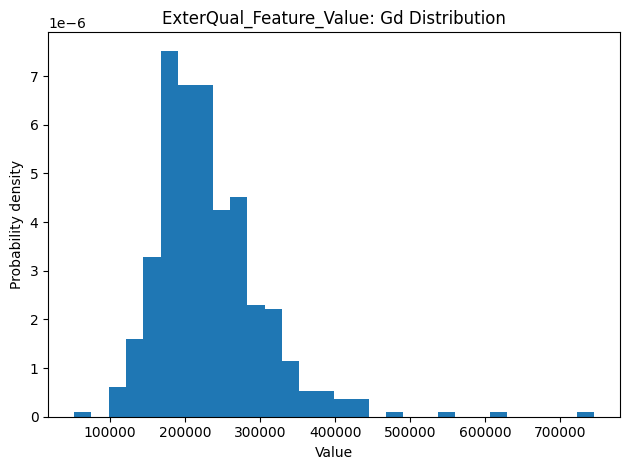

feature: ExterQual feat_val: TA : p value:2.8e-47 statistic:214.35


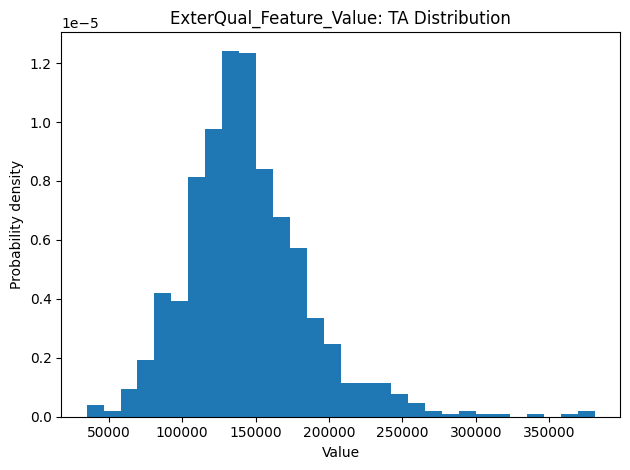

feature: ExterQual feat_val: Ex : p value:0.011 statistic:8.97


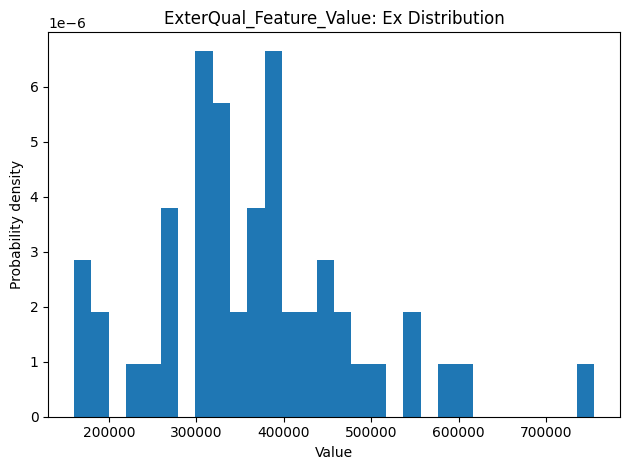

feature: ExterQual feat_val: Fa : p value:0.0018 statistic:12.69


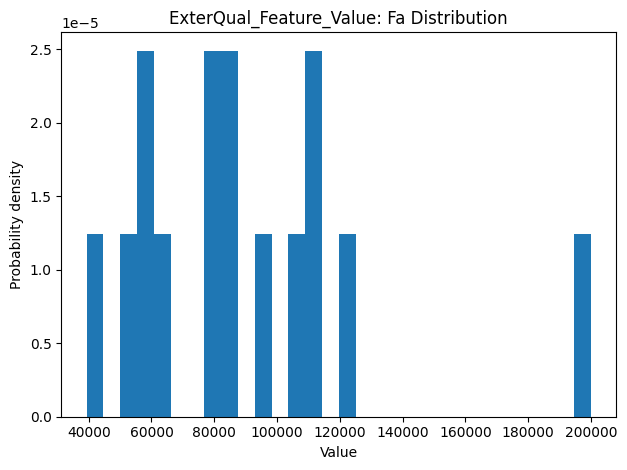

In [555]:
viz_series_dist(df,'ExterQual','SalePrice')

## **2. Data Transformation & Spliting**
### **Summary:**

### **Section Highlights:**


Based on data description, convert various categorical data into rating (int) data, and for featur values without the specic feature, fill null with zero (eg: for no garage, GarageBuilt Yr=0)

In [556]:
def df_conversion(df):
    tr=df.copy()    
    conversion1_feat=['ExterQual',
                 'ExterCond',
                 'BsmtQual',
                 'BsmtCond',
                 'HeatingQC',
                 'KitchenQual',
                 'FireplaceQu',
                 'GarageQual',
                 'GarageCond',
                 'PoolQC',
                 ]
    tr1=tr[conversion1_feat]
    for i in tr1.columns:
        tr1=tr1.replace(
            {
                np.nan:0,
                'Po':1,
                'Fa':2,
                'TA':3,
                'Gd':4,
                'Ex':5
            }
        )

    conversion2_feat=['BsmtExposure',
                  ]
    tr2=tr[conversion2_feat]
    for i in tr2.columns:
        tr2=tr2.replace(
            {
                np.nan:0,
                'No':1,
                'Mn':2,
                'Av':3,
                'Gd':4,
            }
        )

    conversion3_feat=['BsmtFinType1',
                  'BsmtFinType2',
                  ]
    tr3=tr[conversion3_feat]
    for i in tr3.columns:
        tr3=tr3.replace(
            {
                np.nan:0,
                'Unf':1,
                'LwQ':2,
                'Rec':3,
                'BLQ':4,
                'ALQ':5,
                'GLQ':6
            }
        )

    conversion4_feat=['Fence']
    tr4=tr[conversion4_feat]
    for i in tr4.columns:
        tr4=tr4.replace(
            {
                np.nan:0,
                'MnWw':1,
                'GdWo':2,
                'MnPrv':3,
                'GdPrv':4,
            }
        )

    conversion5_feat=['LotFrontage',
                      'GarageYrBlt',
                      'MasVnrArea',
                      'estimated_garage_age(yr)',
                      'estimated_garage_age((month)',
                      #'Electrical'
                      ]
    tr5=tr[conversion5_feat]
    for i in tr5.columns:
        tr5=tr5.replace(
            {
                np.nan:0,
            }
        )

    return pd.concat([tr1,tr2,tr3,tr4,tr5],axis=1)


In [557]:
a=df.copy()

In [558]:
fig = px.box(a, x='YrSold',y='SalePrice')
fig.show()

In [559]:
fig = px.box(a, x='MoSold',y='SalePrice')
fig.show()

In [560]:
fig = px.scatter(a, x='YearBuilt',y='SalePrice')
fig.show()

In [561]:
a['estimated house age(month)']=(a['YrSold']*12+a['MoSold'])-(a['YearBuilt']*12)
fig = px.scatter(a, x='estimated house age(month)',y='SalePrice',color='OverallCond')
fig.show()

In [562]:
def data_transform(df):
    tr=df.copy()
    tr['estimated_house_age(month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['YearBuilt']*12)
    tr['estimated_house_age(yr)']=(tr['YrSold'])-(tr['YearBuilt'])
    #tr['YrMoSold']=(tr['YrSold']*100+tr['MoSold'])
    tr['estimated_remodadd_age(yr)']=(tr['YrSold'])-(tr['YearRemodAdd'])
    tr['estimated_remodadd_age(month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['YearRemodAdd']*12)
    tr['estimated_garage_age(yr)']=(tr['YrSold'])-(tr['GarageYrBlt'])
    tr['estimated_garage_age((month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['GarageYrBlt']*12)
    print(f'New features are created, the df contains {len(tr.columns)} columns;')

    feat_df=tr.drop(['SalePrice','Id'],axis=1)
    print(f'After droping SalePrice and Id columns, it has total {len(feat_df.columns)} features;')
    
    converted_df=df_conversion(tr)
    print(f'Based on the data description, {len(converted_df.columns)} features are converted from categorical into ordinal features, mostly are rating related;')

    feat_df=feat_df.drop(converted_df.columns,axis=1)
    cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
    num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
    num_feat=num_feat.drop('MSSubClass')
    cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
    print(f'After classify MSSubClass from numerical into categorical feature, the df remains {len(cat_feat)} categorical features and {len(num_feat)} numerical features;')

    binary_feat=['Street',  
             'CentralAir',
             ]
    binary_feat_df=tr[list(binary_feat)].apply(le.fit_transform)

    ohe_feat=cat_feat.drop(binary_feat)
    ohe_feat_df=pd.DataFrame(ohe.fit_transform(tr[list(ohe_feat)]).toarray(),columns=ohe.get_feature_names_out())
    print(f'Among the {len(cat_feat)} catergorical features, {len(binary_feat)} are binary features and are converted using Label Encoder;\nRemaining {len(ohe_feat)} categirical features are converted using One-Hot Encoder;')

    #num_exception=['YrSold',
    #               'MoSold',
    #               'YearBuilt',
    #               'YearRemodAdd',
    #               'OverallQual',
    #               'OverallCond',
                   #'GarageYrBlt',
    #               ]

    #num_feat_df=pd.DataFrame(rs.fit_transform(tr[list(num_feat.drop(num_exception))]),columns=rs.get_feature_names_out())
    #print(f'{len(num_exception)} numerical features are related to quality rating and year&month, they are not converted;\nRemaining {len(num_feat_df.columns)} numerical features are converted by Robust Scaler.')

    num_feat_df=pd.DataFrame(rs.fit_transform(tr[list(num_feat)]),columns=rs.get_feature_names_out())
    converted_df=pd.DataFrame(rs.fit_transform(converted_df),columns=rs.get_feature_names_out())

    pro_df=pd.concat([
        tr['SalePrice'],
        #tr[num_exception],
        binary_feat_df,
        ohe_feat_df,
        num_feat_df,
        converted_df
        ],
        axis=1)
    print(f'Final df contains {len(pro_df.columns)} features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder')

    return pro_df
    

In [563]:
pro_df=data_transform(df)

New features are created, the df contains 87 columns;
After droping SalePrice and Id columns, it has total 85 features;
Based on the data description, 19 features are converted from categorical into ordinal features, mostly are rating related;
After classify MSSubClass from numerical into categorical feature, the df remains 30 categorical features and 36 numerical features;
Among the 30 catergorical features, 2 are binary features and are converted using Label Encoder;
Remaining 28 categirical features are converted using One-Hot Encoder;
Final df contains 262 features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder


In [564]:
missing_feat(pro_df)

Features with missing values


,Feature,Total Transaction,Transaction with Missing Value,Missing %


,Feature,Total Transaction,Transaction with Missing Value,Missing %
0,SalePrice,1460,0,0.0000
1,GarageType_nan,1460,0,0.0000
2,GarageFinish_RFn,1460,0,0.0000
3,GarageFinish_Unf,1460,0,0.0000
4,GarageFinish_nan,1460,0,0.0000
...,...,...,...,...
257,RoofMatl_Membran,1460,0,0.0000
258,RoofMatl_Metal,1460,0,0.0000
259,RoofMatl_Roll,1460,0,0.0000
260,RoofMatl_Tar&Grv,1460,0,0.0000


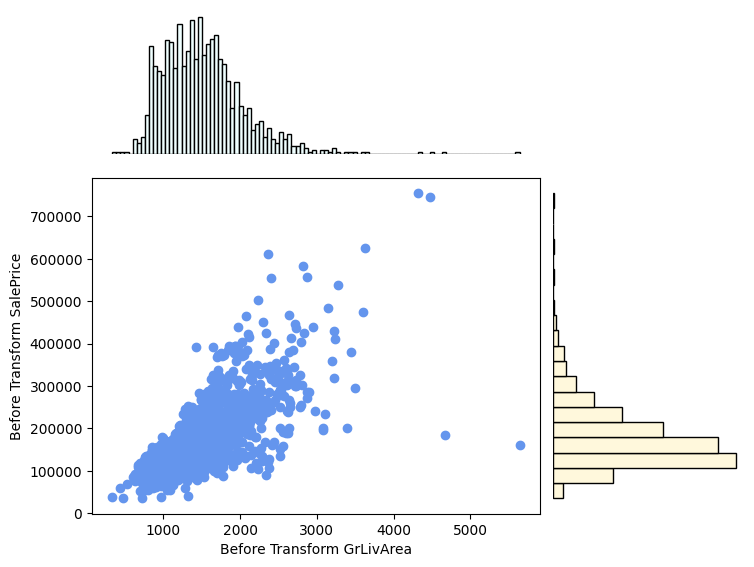

In [565]:
left, width = 1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]
rect_histy = [left_h, bottom, 0.3, height]
ax_scatter = plt.axes(rect_scatter)
rect_scatter=plt.scatter(df['GrLivArea'], df['SalePrice'],color='cornflowerblue')
plt.xlabel("Before Transform GrLivArea")
plt.ylabel("Before Transform SalePrice")
ax_histx = plt.axes(rect_histx)
plt.hist(df['GrLivArea'],bins=100,edgecolor='black',color='azure')
plt.axis('off')

ax_histy = plt.axes(rect_histy)
plt.hist(df['SalePrice'],orientation='horizontal',bins=20,edgecolor='black',color='cornsilk')
plt.axis('off')

plt.show()

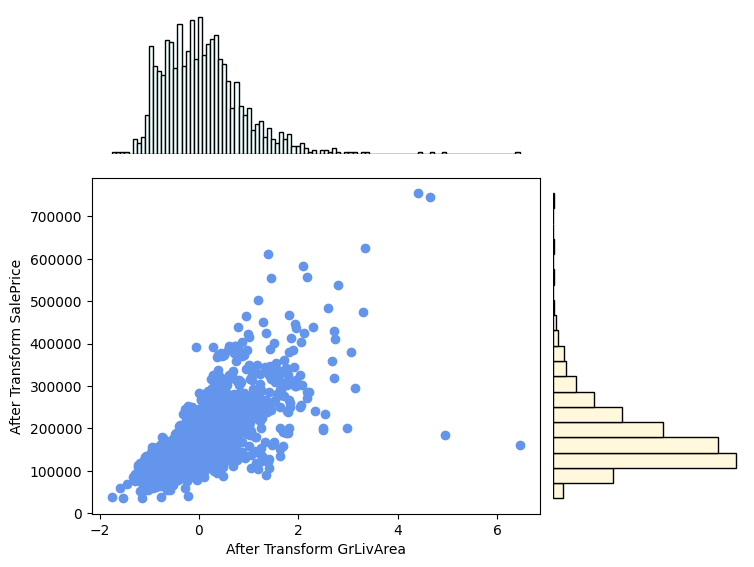

In [566]:
left, width = 1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]
rect_histy = [left_h, bottom, 0.3, height]
ax_scatter = plt.axes(rect_scatter)
rect_scatter=plt.scatter(pro_df['GrLivArea'], pro_df['SalePrice'],color='cornflowerblue')
plt.xlabel("After Transform GrLivArea")
plt.ylabel("After Transform SalePrice")
ax_histx = plt.axes(rect_histx)
plt.hist(pro_df['GrLivArea'],bins=100,edgecolor='black',color='azure')
plt.axis('off')

ax_histy = plt.axes(rect_histy)
plt.hist(pro_df['SalePrice'],orientation='horizontal',bins=20,edgecolor='black',color='cornsilk')
plt.axis('off')

plt.show()

## **3. Model Selection**
### **Summary:**


### **Section Highlights:**

In [ ]:
t_pro_df_tr,t_pro_df_tst=train_test_split(pro_df.sort_values(by=['YrSold','MoSold']),train_size=0.8,shuffle=False)

In [567]:
pro_df_tr,pro_df_tst=train_test_split(pro_df,train_size=0.8,shuffle=True)

In [568]:
def cv_reg(df,split_type):
    #initialize score
    tr_df=df.copy()

    LRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    GBRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    XGBRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    RGscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LARSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    DTRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    SVRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    RFRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LSLARSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }

    if split_type=='time':
        tr_df=tr_df.sort_values(by=['YrSold','MoSold'])
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            if i==0:
                b=a[i]
            #continue merging different data set and train
            if i>0:
                b=pd.concat([b,a[i]],axis=0)
            k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
            #assign validation set
            train_x_=k_tr.drop('SalePrice',axis=1)
            train_y_=k_tr['SalePrice']
            val_x_=k_val.drop('SalePrice',axis=1)
            val_y_=k_val['SalePrice']

            LRModel=LR()
            LRModel.fit(train_x_, train_y_)
            pred_=LRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LRModel.n_features_in_-1)
            LRscore['R2'][i]=r2_
            LRscore['RMSE'][i]=rmse_
            LRscore['Adj_R2'][i]=adj_r2_
            result={'LinearReg':LRscore}

            GBRModel=GBR(n_estimators=1000,learning_rate=0.01)
            GBRModel.fit(train_x_, train_y_)
            pred_=GBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-GBRModel.n_features_in_-1)            
            GBRscore['R2'][i]=r2_
            GBRscore['RMSE'][i]=rmse_
            GBRscore['Adj_R2'][i]=adj_r2_            
            result.update({'GradientBoostReg':GBRscore})

            XGBRModel=XGBR(n_estimators=1000,learning_rate=0.01)
            XGBRModel.fit(train_x_, train_y_)
            pred_=XGBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-XGBRModel.n_features_in_-1)
            XGBRscore['R2'][i]=r2_
            XGBRscore['RMSE'][i]=rmse_
            XGBRscore['Adj_R2'][i]=adj_r2_
            result.update({'XGBReg':XGBRscore})

            RGModel=RG(alpha=0.1)
            RGModel.fit(train_x_, train_y_)
            pred_=RGModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RGModel.n_features_in_-1)
            RGscore['R2'][i]=r2_
            RGscore['RMSE'][i]=rmse_
            RGscore['Adj_R2'][i]=adj_r2_
            result.update({'Ridge':RGscore})

            LSModel=Lasso
            LSModel.fit(train_x_, train_y_)
            pred_=LSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSModel.n_features_in_-1)
            LSscore['R2'][i]=r2_
            LSscore['RMSE'][i]=rmse_
            LSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lasso':LSscore})            

            LARSModel=Lars
            LARSModel.fit(train_x_, train_y_)
            pred_=LARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LARSModel.n_features_in_-1)
            LARSscore['R2'][i]=r2_
            LARSscore['RMSE'][i]=rmse_
            LARSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lars':LARSscore})

            DTRModel=DTR(max_depth=5)
            DTRModel.fit(train_x_, train_y_)
            pred_=DTRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-DTRModel.n_features_in_-1)
            DTRscore['R2'][i]=r2_
            DTRscore['RMSE'][i]=rmse_
            DTRscore['Adj_R2'][i]=adj_r2_
            result.update({'DecisionTreeReg':DTRscore})

            SVRModel=SVR(C=100)
            SVRModel.fit(train_x_, train_y_)
            pred_=SVRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-SVRModel.n_features_in_-1)
            SVRscore['R2'][i]=r2_
            SVRscore['RMSE'][i]=rmse_
            SVRscore['Adj_R2'][i]=adj_r2_
            result.update({'SupportVectorReg':SVRscore})

            RFRModel=RFR(n_estimators=1000,)
            RFRModel.fit(train_x_, train_y_)
            pred_=RFRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RFRModel.n_features_in_-1)
            RFRscore['R2'][i]=r2_
            RFRscore['RMSE'][i]=rmse_
            RFRscore['Adj_R2'][i]=adj_r2_            
            result.update({'RandomForestReg':RFRscore})
            
            LSLARSModel=LassoLars
            LSLARSModel.fit(train_x_, train_y_)
            pred_=LSLARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSLARSModel.n_features_in_-1)
            LSLARSscore['R2'][i]=r2_
            LSLARSscore['RMSE'][i]=rmse_
            LSLARSscore['Adj_R2'][i]=adj_r2_            
            result.update({'LassoLars':LSLARSscore})

            print(result)

    if split_type=='random':
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            b=a.copy()
            val_x_=b[i].drop('SalePrice',axis=1)
            val_y_=b[i]['SalePrice']
            del b[i]
            k_tr=pd.DataFrame()
            for j in range(len(b)):
                k_tr=pd.concat([k_tr,b[j]],axis=0)
            train_x_=k_tr.drop('SalePrice',axis=1)
            train_y_=k_tr['SalePrice']

            LRModel=LR()
            LRModel.fit(train_x_, train_y_)
            pred_=LRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LRModel.n_features_in_-1)
            LRscore['R2'][i]=r2_
            LRscore['RMSE'][i]=rmse_
            LRscore['Adj_R2'][i]=adj_r2_
            result={'LinearReg':LRscore}

            GBRModel=GBR(n_estimators=1000,learning_rate=0.01)
            GBRModel.fit(train_x_, train_y_)
            pred_=GBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-GBRModel.n_features_in_-1)            
            GBRscore['R2'][i]=r2_
            GBRscore['RMSE'][i]=rmse_
            GBRscore['Adj_R2'][i]=adj_r2_            
            result.update({'GradientBoostReg':GBRscore})

            XGBRModel=XGBR(n_estimators=1000,learning_rate=0.01)
            XGBRModel.fit(train_x_, train_y_)
            pred_=XGBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-XGBRModel.n_features_in_-1)
            XGBRscore['R2'][i]=r2_
            XGBRscore['RMSE'][i]=rmse_
            XGBRscore['Adj_R2'][i]=adj_r2_
            result.update({'XGBReg':XGBRscore})

            RGModel=RG(alpha=0.1)
            RGModel.fit(train_x_, train_y_)
            pred_=RGModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RGModel.n_features_in_-1)
            RGscore['R2'][i]=r2_
            RGscore['RMSE'][i]=rmse_
            RGscore['Adj_R2'][i]=adj_r2_
            result.update({'Ridge':RGscore})

            LSModel=Lasso
            LSModel.fit(train_x_, train_y_)
            pred_=LSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSModel.n_features_in_-1)
            LSscore['R2'][i]=r2_
            LSscore['RMSE'][i]=rmse_
            LSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lasso':LSscore})            

            LARSModel=Lars
            LARSModel.fit(train_x_, train_y_)
            pred_=LARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LARSModel.n_features_in_-1)
            LARSscore['R2'][i]=r2_
            LARSscore['RMSE'][i]=rmse_
            LARSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lars':LARSscore})

            DTRModel=DTR(max_depth=5)
            DTRModel.fit(train_x_, train_y_)
            pred_=DTRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-DTRModel.n_features_in_-1)
            DTRscore['R2'][i]=r2_
            DTRscore['RMSE'][i]=rmse_
            DTRscore['Adj_R2'][i]=adj_r2_
            result.update({'DecisionTreeReg':DTRscore})

            SVRModel=SVR(C=100)
            SVRModel.fit(train_x_, train_y_)
            pred_=SVRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-SVRModel.n_features_in_-1)
            SVRscore['R2'][i]=r2_
            SVRscore['RMSE'][i]=rmse_
            SVRscore['Adj_R2'][i]=adj_r2_
            result.update({'SupportVectorReg':SVRscore})

            RFRModel=RFR(n_estimators=1000,)
            RFRModel.fit(train_x_, train_y_)
            pred_=RFRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RFRModel.n_features_in_-1)
            RFRscore['R2'][i]=r2_
            RFRscore['RMSE'][i]=rmse_
            RFRscore['Adj_R2'][i]=adj_r2_            
            result.update({'RandomForestReg':RFRscore})
            
            LSLARSModel=LassoLars
            LSLARSModel.fit(train_x_, train_y_)
            pred_=LSLARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSLARSModel.n_features_in_-1)
            LSLARSscore['R2'][i]=r2_
            LSLARSscore['RMSE'][i]=rmse_
            LSLARSscore['Adj_R2'][i]=adj_r2_            
            result.update({'LassoLars':LSLARSscore})

            print(result)

    return pd.DataFrame(result)

In [569]:
def split_result(df):
    result1=pd.DataFrame()
    score_dict={}
    for c in df.columns:
        for i in df.index:
            model=[]
            score_list=[]
            for cv in range(0,len(df[df.columns[0]][0])):
                score_list.append(df[c][i][round(cv,4)])
                model.append(c)
            score_dict.update({'model':model,i:score_list})
            result2=pd.DataFrame(score_dict)
        #print(result2)
        #print(c)
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

In [570]:
def avg_summary(df):
    result1=pd.DataFrame()
    score_dict={}
    for m in df['model'].unique():
        for i in df.columns.drop('model'):
            score_dict.update({'model':m,i:sum(df.loc[df['model']==m][i])/len(df.loc[df['model']==m])})
        result2=pd.DataFrame(score_dict,index=[m])
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

Time-base Split CV Model Screening

In [571]:
pd.options.display.float_format = '{:.4f}'.format

Summary of Time-Based Split CV Model screening result shows that GradientBoot has the lowest average RMSE and good R2. The poor Adj_R2 indicates that most features used by all models do not improve the model predictions.

In [ ]:
result=cv_reg(t_pro_df_tr,'time')

In [ ]:
screening=split_result(result)
print(avg_summary(screening).sort_values(by='RMSE',ascending=True))

In [ ]:
selected_model=screening[screening['model'].isin([
            'XGBReg',
            'RandomForestReg',
            'GradientBoostReg',
            'Ridge',
            #'Lasso',
            'DecisionTreeReg',
            'LassoLars',
            #'Lars',
            #'SupportVectorReg',
            #'LinearReg',
            ])]

for i in screening.columns.drop('model'):
    fig = px.box(
        selected_model,
            x='model',
            y=i,title=i)
    fig.add_trace(go.Scatter(x=selected_model['model'],y=selected_model[i],mode='markers',name='5-fold Cross Validation'),)
    fig.show()

Summary of Random Split CV Model screening result shows that GradientBoot has the lowest average RMSE and good R2. The poor Adj_R2 indicates that most features used by all models do not improve the model predictions.

In [572]:
result=cv_reg(pro_df_tr,'random')

{'LinearReg': {'R2': [0.8702726922768028, 100, 100, 100, 100], 'RMSE': [26172.376977816493, 100, 100, 100, 100], 'Adj_R2': [2.0795165249823193, 100, 100, 100, 100]}, 'GradientBoostReg': {'R2': [0.9039964986773964, 100, 100, 100, 100], 'RMSE': [22514.950720227083, 100, 100, 100, 100], 'Adj_R2': [1.7988862788630944, 100, 100, 100, 100]}, 'XGBReg': {'R2': [0.904022660255668, 100, 100, 100, 100], 'RMSE': [22511.8827759787, 100, 100, 100, 100], 'Adj_R2': [1.7986685771581912, 100, 100, 100, 100]}, 'Ridge': {'R2': [0.8718571082035883, 100, 100, 100, 100], 'RMSE': [26012.058663653483, 100, 100, 100, 100], 'Adj_R2': [2.06633192102014, 100, 100, 100, 100]}, 'Lasso': {'R2': [0.8702101958830131, 100, 100, 100, 100], 'RMSE': [26178.68051658648, 100, 100, 100, 100], 'Adj_R2': [2.080036584259213, 100, 100, 100, 100]}, 'Lars': {'R2': [-2.3217116825013363e+50, 100, 100, 100, 100], 'RMSE': [1.1072141003648658e+30, 100, 100, 100, 100], 'Adj_R2': [1.931995792938612e+51, 100, 100, 100, 100]}, 'DecisionTree

In [573]:
screening=split_result(result)
print(avg_summary(screening).sort_values(by='RMSE',ascending=True))

              model                                                 R2  \
1  GradientBoostReg                                             0.8809   
2            XGBReg                                             0.8707   
8   RandomForestReg                                             0.8548   
9         LassoLars                                             0.8037   
4             Lasso                                             0.7901   
3             Ridge                                             0.7890   
0         LinearReg                                             0.7838   
6   DecisionTreeReg                                             0.7350   
7  SupportVectorReg                                            -0.0594   
5              Lars -1665705474371456724482752819885226941431598867...   

                                             RMSE  \
1                                      26939.2642   
2                                      28147.4650   
8                         

In [577]:
selected_model=screening[screening['model'].isin([
            'XGBReg',
            'RandomForestReg',
            'GradientBoostReg',
            'Ridge',
            'Lasso',
            'DecisionTreeReg',
            'LassoLars',
            #'Lars',
            #'SupportVectorReg',
            'LinearReg',
            ])]

for i in screening.columns.drop('model'):
    fig = px.box(
        selected_model,
            x='model',
            y=i,title=i)
    fig.add_trace(go.Scatter(x=selected_model['model'],y=selected_model[i],mode='markers',name='5-fold Cross Validation'),)
    fig.show()

## **4. Baseline Model Creation**
### **Summary:**


### **Section Highlights:**


In [578]:
def reg_result(model,val_x,val_y):
    pred_=model.predict(val_x)
    rmse_=root_mean_squared_error(val_y,pred_)
    r2_=r2_score(val_y,pred_)
    adj_r2_=1-(1-r2_)*(len(val_x)-1)/(len(val_x)-model.n_features_in_-1)

    print(f'RMSE:${round(rmse_):,} R2:%.4f Adj R2:%.4f'%(r2_,adj_r2_))

    fig = px.line(
        x=val_y,
        y=val_y,
        title='Predict vs Actual',
        )
    fig.add_trace(
        go.Scatter(x=val_y,y=pred_,mode='markers',name='Model Prediction')
    )
    fig.update_layout(
        xaxis_title="Actual House Price", 
        yaxis_title="Predicted House Price"
        )
    fig.update_layout()
    fig.show()

GradientBoostingRegressor

In [ ]:
t_x_tr=t_pro_df_tr.drop('SalePrice',axis=1)
t_y_tr=t_pro_df_tr['SalePrice']
t_x_tst=t_pro_df_tst.drop('SalePrice',axis=1)
t_y_tst=t_pro_df_tst['SalePrice']

In [589]:
x_tr=pro_df_tr.drop('SalePrice',axis=1)
y_tr=pro_df_tr['SalePrice']
x_tst=pro_df_tst.drop('SalePrice',axis=1)
y_tst=pro_df_tst['SalePrice']

In [580]:
def opt_gbr_model(hpdict,train_x,train_y):

    GBRmodel=GBR(
        alpha=hpdict['alpha'],
        ccp_alpha=hpdict['ccp_alpha'],
        criterion=hpdict['criterion'],
        #init=hpdict['init'],
        learning_rate=hpdict['learning_rate'],
        loss=hpdict['loss'],
        max_depth=hpdict['max_depth'],
        #max_features=hpdict['max_features'],
        max_leaf_nodes=hpdict['max_leaf_nodes'],
        min_impurity_decrease=hpdict['min_impurity_decrease'],
        min_samples_leaf=hpdict['min_samples_leaf'],
        min_samples_split=hpdict['min_samples_split'],
        min_weight_fraction_leaf=hpdict['min_weight_fraction_leaf'],
        n_estimators=1000,
        #n_estimators=hpdict['n_estimators'],
        #n_iter_no_change=hpdict['n_iter_no_change'],
        random_state=1,
        #random_state=hpdict['random_state'],
        subsample=hpdict['subsample'],
        tol=hpdict['tol'],
        validation_fraction=hpdict['validation_fraction'],
        verbose=0,
        #warm_start=hpdict['warm_start']
        )

    GBRmodel.fit(train_x,train_y,)

    return GBRmodel

In [587]:
hp_example={
'alpha': 0.1,
'ccp_alpha': 0.1,
'criterion': 'friedman_mse',
#'init': None,
'learning_rate': 0.1,
'loss': 'squared_error',
'max_depth': 5,
#'max_features': None,
'max_leaf_nodes': 2,
'min_impurity_decrease': 5,
'min_samples_leaf': 1,
'min_samples_split': 2,
'min_weight_fraction_leaf': 0.1,
#'n_estimators': 1000,
#'n_iter_no_change': None,
#'random_state': None,
'subsample': 0.5,
'tol': 0.0001,
'validation_fraction': 0.1,
'verbose': 0,
#'warm_start': False,
}

In [633]:
Model0=opt_gbr_model(hp_example,x_tr,y_tr)
print('Train Data Result')
reg_result(Model0,x_tr,y_tr)
print('Test Data Result')
reg_result(Model0,x_tst,y_tst)

Train Data Result
RMSE:$27,795 R2:0.8749 Adj R2:0.8389


Test Data Result
RMSE:$28,014 R2:0.8831 Adj R2:-0.1336


In [583]:
def objective_random_cv_gbr(trial):
   
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',0,1),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',0,1000),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',0,0.3),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0,1000),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    'min_samples_split': trial.suggest_uniform('min_samples_split', 0.0001,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0,0.5),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample', 0.001,1),
    'tol': trial.suggest_uniform('tol', 0.0,100),
    'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)

    return best_score

In [ ]:
def objective_time_cv_gbr(trial):
   
    tr_df=t_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',0,1),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',0,1000),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',0,0.3),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0,1000),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    'min_samples_split': trial.suggest_uniform('min_samples_split', 0.0001,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0,0.5),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample', 0.001,1),
    'tol': trial.suggest_uniform('tol', 0.0,100),
    'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [591]:
study1 = optuna.create_study(direction="minimize")
study1.optimize(objective_random_cv_gbr, n_trials=100)
hp01=study1.best_params

[I 2024-07-05 13:59:30,991] A new study created in memory with name: no-name-461d9fc8-90d4-4444-a0d3-cd732dc025b6
[I 2024-07-05 13:59:52,058] Trial 0 finished with value: 43575.0 and parameters: {'alpha': 0.7582591140280356, 'ccp_alpha': 386.2443989754912, 'criterion': 'squared_error', 'learning_rate': 0.19374476085137507, 'loss': 'huber', 'max_depth': 8, 'max_leaf_nodes': 9, 'min_impurity_decrease': 835.8005674000552, 'min_samples_leaf': 83, 'min_samples_split': 0.3898070720752758, 'min_weight_fraction_leaf': 0.0015523218102145853, 'subsample': 0.9309451468148178, 'tol': 11.624869339341936, 'validation_fraction': 0.8839707443244977}. Best is trial 0 with value: 43575.0.
[I 2024-07-05 13:59:53,277] Trial 1 finished with value: 94889.0 and parameters: {'alpha': 0.20941877581504942, 'ccp_alpha': 315.7701348999018, 'criterion': 'squared_error', 'learning_rate': 0.04985260082017706, 'loss': 'squared_error', 'max_depth': 12, 'max_leaf_nodes': 49, 'min_impurity_decrease': 917.485628846483, '

In [592]:
hp01

{'alpha': 0.6155713631680202,
 'ccp_alpha': 1.1990730831090666,
 'criterion': 'squared_error',
 'learning_rate': 0.09183958716229701,
 'loss': 'squared_error',
 'max_depth': 8,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 58.40838198215521,
 'min_samples_leaf': 31,
 'min_samples_split': 0.5874567268811963,
 'min_weight_fraction_leaf': 0.01353605926353191,
 'subsample': 0.9518583175384682,
 'tol': 75.99455151125305,
 'validation_fraction': 0.6798389419821277}

Using Optuna, the hyperparameter is optimized and better RMSE result in Test data. However,
1. The Train data is extremely well and much better than Test data, this likely caused by overfitting. In the next optimization, 'loss':'squared_error' should be removed from optimization search space.
2. Adjusted R2 of Test Data is very poor, indicate that most features used are not helping model to explain the 'SalePrice' variation and should be removed.

In [705]:
Model1=opt_gbr_model(hp01,x_tr,y_tr)
print('Train Data Result')
reg_result(Model1,x_tr,y_tr)
print('Test Data Result')
reg_result(Model1,x_tst,y_tst)

Train Data Result
RMSE:$8,371 R2:0.9887 Adj R2:0.9854


Test Data Result
RMSE:$25,282 R2:0.9048 Adj R2:0.0767


In [594]:
optuna.visualization.plot_param_importances(study1)

## **5. Feature Engineering and Model Tunning**
### **Summary:**


### **Section Highlights:**


In [595]:
def feat_importance(model):
    feat_df=pd.DataFrame(data={'Feature':model.feature_names_in_,'Importance':model.feature_importances_,})
    print('Total feature count is',len(feat_df['Feature']))

    print('Top 20 Important Features')
    display(feat_df.sort_values(by='Importance',ascending=False).head(20))

    fig = px.bar(feat_df.sort_values(by='Importance',ascending=True),text_auto=True, y='Feature', x='Importance',orientation='h',title="Feature Importance")
    fig.show()

    fig = px.histogram(feat_df, x="Importance",histnorm='percent',nbins=5*len(feat_df),marginal='box',title="Feature Importance Distribution")
    fig.show()

    fig = px.ecdf(feat_df, x="Importance",marginal="histogram",title="Cumulative Distribution of Feature Importance")
    fig.show()

    return feat_df

In [706]:
model_feat1=feat_importance(Model1)

Total feature count is 261
Top 20 Important Features


,Feature,Importance
207,OverallQual,0.4292
218,GrLivArea,0.1359
227,GarageCars,0.0670
211,BsmtFinSF1,0.0503
214,TotalBsmtSF,0.0486
242,ExterQual,0.0285
244,BsmtQual,0.0272
206,LotArea,0.0219
247,KitchenQual,0.0165
228,GarageArea,0.0127


In [597]:

#select feature based on importance values
def select_feat(model_feat,criteria):
    fe_to_select=model_feat[model_feat['Importance']>criteria]
    fe_to_remove=model_feat[model_feat['Importance']<=criteria]

    print(f'Total {len(fe_to_remove)} features to be removed based on criteria lower than',criteria)
    display(fe_to_remove.sort_values(by='Importance',ascending=False))

    print(f'Total {len(fe_to_select)} features to be retained based on criteria higher than',criteria)
    display(fe_to_select.sort_values(by='Importance',ascending=False))

    return fe_to_select,fe_to_remove

In [615]:
#select feature by importance ranking
def select_feat2(model_feat,top):
    fe_to_select=model_feat.sort_values('Importance',ascending=False).head(top)
    fe_to_remove=model_feat.sort_values('Importance',ascending=False).tail(len(model_feat)-top)

    print(f'Total {len(fe_to_remove)} features to be removed based on ranking out of top',top)
    display(fe_to_remove.sort_values(by='Importance',ascending=False))

    print(f'Total {len(fe_to_select)} features to be retained based on ranking of top',top)
    display(fe_to_select.sort_values(by='Importance',ascending=False))

    return fe_to_select,fe_to_remove

In [ ]:
def update_feat(fe_to_remove,pro_df_tr_,tr_x_,tst_x_):
    fe_pro_df_tr_=pro_df_tr_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tr_x_=tr_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tst_x_=tst_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    return fe_pro_df_tr_,fe_tr_x_,fe_tst_x_

In [707]:
selected_feat,remove_feat=select_feat(model_feat1,0)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,pro_df_tr,x_tr,x_tst)

Total 141 features to be removed based on criteria lower than 0


,Feature,Importance
0,Street,0.0000
149,Electrical_nan,0.0000
142,Heating_OthW,0.0000
143,Heating_Wall,0.0000
144,Electrical_FuseA,0.0000
...,...,...
77,HouseStyle_1Story,0.0000
76,HouseStyle_1.5Unf,0.0000
73,BldgType_Twnhs,0.0000
71,BldgType_2fmCon,0.0000


Total 120 features to be retained based on criteria higher than 0


,Feature,Importance
207,OverallQual,0.4292
218,GrLivArea,0.1359
227,GarageCars,0.0670
211,BsmtFinSF1,0.0503
214,TotalBsmtSF,0.0486
...,...,...
72,BldgType_Duplex,0.0000
117,Exterior2nd_CmentBd,0.0000
16,LandContour_Low,0.0000
202,MSSubClass_120,0.0000


In [ ]:
#selected_feat,remove_feat=select_feat2(model_feat1,261)

After filter out zero importance features, significant improvement of Adjusted R2 in Test Data is obtained.

In [708]:
Model1=opt_gbr_model(hp01,fe_x_tr,y_tr)
print('Train Data Result')
reg_result(Model1,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model1,fe_x_tst,y_tst)

Train Data Result
RMSE:$8,371 R2:0.9887 Adj R2:0.9874


Test Data Result
RMSE:$25,281 R2:0.9048 Adj R2:0.8380


New objective_random_cv_gbr_fe function will use selected features and previous hyperparameter for optimization. Also it removes 'squared_error' from 'loss' hyperparameter search space to reduce overfiting into Train Data.

In [638]:
def objective_random_cv_gbr_fe(trial):
   
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['absolute_error','huber','quantile']#'squared_error',
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-100),min(hp_optuna['ccp_alpha']+100,1000)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',max(2,hp_optuna["max_leaf_nodes"]-5),min(hp_optuna["max_leaf_nodes"]+5,100)),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-100),min(hp_optuna['min_impurity_decrease']+100,1000)),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',max(1,hp_optuna["min_samples_leaf"]-10),min(hp_optuna["min_samples_leaf"]+10,100)),
    'min_samples_split': trial.suggest_uniform('min_samples_split',max(0,hp_optuna["min_samples_split"]-0.1),min(hp_optuna["min_samples_split"]+0.1,1)),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,0.5)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,1)),
    'tol': trial.suggest_uniform('tol',max(0,hp_optuna['tol']-10),min(hp_optuna['tol']+10,100)),
    'validation_fraction': trial.suggest_uniform('validation_fraction',max(0,hp_optuna['validation_fraction']-0.1),min(hp_optuna['validation_fraction']+0.1,1)),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)


    return best_score

In [639]:
#pass hp01 as default parameter for optimization in objective_random_cv_gbr_fe
hp_optuna=hp01

study2 = optuna.create_study(direction="minimize")
study2.optimize(objective_random_cv_gbr_fe, n_trials=100)
hp02=study2.best_params

[I 2024-07-05 14:44:20,086] A new study created in memory with name: no-name-84a3e591-4819-4541-a8c0-2cc8018c4865
[I 2024-07-05 14:44:27,082] Trial 0 finished with value: 79135.2 and parameters: {'alpha': 0.5448644098563397, 'ccp_alpha': 57.71710327290928, 'criterion': 'friedman_mse', 'learning_rate': 0.15339901262125177, 'loss': 'quantile', 'max_depth': 10, 'max_leaf_nodes': 8, 'min_impurity_decrease': 142.23685592114998, 'min_samples_leaf': 41, 'min_samples_split': 0.626991892910403, 'min_weight_fraction_leaf': 0.05835291334587212, 'subsample': 0.8812643535137155, 'tol': 79.43014472912074, 'validation_fraction': 0.7053144927568225}. Best is trial 0 with value: 79135.2.
[I 2024-07-05 14:44:37,816] Trial 1 finished with value: 79703.4 and parameters: {'alpha': 0.5170906378085612, 'ccp_alpha': 61.58644049240945, 'criterion': 'friedman_mse', 'learning_rate': 0.1428543532339278, 'loss': 'quantile', 'max_depth': 8, 'max_leaf_nodes': 11, 'min_impurity_decrease': 76.61040624835043, 'min_samp

In [709]:
hp02

{'alpha': 0.6884225110065869,
 'ccp_alpha': 74.85819625210968,
 'criterion': 'squared_error',
 'learning_rate': 0.09208634059912961,
 'loss': 'huber',
 'max_depth': 11,
 'max_leaf_nodes': 8,
 'min_impurity_decrease': 145.87056631249055,
 'min_samples_leaf': 25,
 'min_samples_split': 0.5476968723113738,
 'min_weight_fraction_leaf': 0.0101411989836954,
 'subsample': 0.9420116324031766,
 'tol': 83.96393543386779,
 'validation_fraction': 0.6145845061572641}

Model2 Train Data RMSE is poorer than Model1, but better RMSE in Test Data, and the performance difference between the two data sets are smaller, indicate that Model2 is a more generalized model and less overfitting.

In [710]:
Model2=opt_gbr_model(hp02,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(Model2,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model2,fe_x_tst,y_tst)

Training Data Result
RMSE:$21,378 R2:0.9260 Adj R2:0.9175


Test Data Result
RMSE:$24,408 R2:0.9113 Adj R2:0.8490


From hyperparameter importance, since 'loss' is the most critical parameter, we will fix 'loss' hyperparameter and try to optimize others.

In [643]:
optuna.visualization.plot_param_importances(study2)

In [679]:
def objective_random_cv_gbr_fe2(trial):
   
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['absolute_error','huber','quantile']#'squared_error',
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-100),min(hp_optuna['ccp_alpha']+100,1000)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss':'huber',
    #'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',max(2,hp_optuna["max_leaf_nodes"]-5),min(hp_optuna["max_leaf_nodes"]+5,100)),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-100),min(hp_optuna['min_impurity_decrease']+100,1000)),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',max(1,hp_optuna["min_samples_leaf"]-10),min(hp_optuna["min_samples_leaf"]+10,100)),
    'min_samples_split': trial.suggest_uniform('min_samples_split',max(0,hp_optuna["min_samples_split"]-0.1),min(hp_optuna["min_samples_split"]+0.1,1)),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,0.5)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,1)),
    'tol': trial.suggest_uniform('tol',max(0,hp_optuna['tol']-10),min(hp_optuna['tol']+10,100)),
    'validation_fraction': trial.suggest_uniform('validation_fraction',max(0,hp_optuna['validation_fraction']-0.1),min(hp_optuna['validation_fraction']+0.1,1)),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)


    return best_score

In [717]:
model_feat2=feat_importance(Model2)
selected_feat,remove_feat=select_feat(model_feat2,0)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,fe_pro_df_tr,fe_x_tr,fe_x_tst)

Total feature count is 105
Top 20 Important Features


,Feature,Importance
58,OverallQual,0.3034
68,GrLivArea,0.1644
65,TotalBsmtSF,0.0650
88,ExterQual,0.0621
93,KitchenQual,0.0506
85,estimated_house_age(month),0.0487
78,GarageArea,0.0423
62,BsmtFinSF1,0.0283
94,FireplaceQu,0.0265
57,LotArea,0.0257


Total 0 features to be removed based on criteria lower than 0


,Feature,Importance


Total 105 features to be retained based on criteria higher than 0


,Feature,Importance
58,OverallQual,0.3034
68,GrLivArea,0.1644
65,TotalBsmtSF,0.0650
88,ExterQual,0.0621
93,KitchenQual,0.0506
...,...,...
5,LotShape_Reg,0.0000
4,LotShape_IR1,0.0000
98,BsmtFinType2,0.0000
51,SaleCondition_Normal,0.0000


In [718]:
Model2=opt_gbr_model(hp02,fe_x_tr,y_tr)
print('Train Data Result')
reg_result(Model2,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model2,fe_x_tst,y_tst)

Train Data Result
RMSE:$21,471 R2:0.9253 Adj R2:0.9180


Test Data Result
RMSE:$24,352 R2:0.9117 Adj R2:0.8618


In [719]:
hp_optuna=hp02

study3 = optuna.create_study(direction="minimize")
study3.optimize(objective_random_cv_gbr_fe2, n_trials=100)
hp03=study3.best_params

[I 2024-07-05 16:28:49,647] A new study created in memory with name: no-name-efca470e-160d-428c-970a-2a586c3e03fe
[I 2024-07-05 16:29:08,929] Trial 0 finished with value: 31588.4 and parameters: {'alpha': 0.6926494059391193, 'ccp_alpha': 146.0567685976076, 'criterion': 'squared_error', 'learning_rate': 0.0088476737819057, 'max_depth': 9, 'max_leaf_nodes': 7, 'min_impurity_decrease': 241.72530145498288, 'min_samples_leaf': 31, 'min_samples_split': 0.557653230749549, 'min_weight_fraction_leaf': 0.023857329180361684, 'subsample': 0.985234615412952, 'tol': 93.00795105077135, 'validation_fraction': 0.5224228212427472}. Best is trial 0 with value: 31588.4.
[I 2024-07-05 16:29:22,891] Trial 1 finished with value: 29852.6 and parameters: {'alpha': 0.5946055721695357, 'ccp_alpha': 28.014444919736643, 'criterion': 'friedman_mse', 'learning_rate': 0.05927083284065529, 'max_depth': 14, 'max_leaf_nodes': 5, 'min_impurity_decrease': 67.72076616716336, 'min_samples_leaf': 30, 'min_samples_split': 0.5

In [720]:
hp03

{'alpha': 0.7101481770786096,
 'ccp_alpha': 77.45334320014206,
 'criterion': 'squared_error',
 'learning_rate': 0.0985647116988758,
 'max_depth': 8,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 56.9351306613292,
 'min_samples_leaf': 17,
 'min_samples_split': 0.6076343810051174,
 'min_weight_fraction_leaf': 0.013538538693111942,
 'subsample': 0.9380677551030832,
 'tol': 80.25781357761598,
 'validation_fraction': 0.5957047579977274}

In [721]:
hp03.update({'loss':'huber'})

In [722]:
Model3=opt_gbr_model(hp03,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(Model3,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model3,fe_x_tst,y_tst)

Training Data Result
RMSE:$20,621 R2:0.9311 Adj R2:0.9243


Test Data Result
RMSE:$24,719 R2:0.9090 Adj R2:0.8576


In [723]:
optuna.visualization.plot_param_importances(study3)

In [724]:
model_feat3=feat_importance(Model3)

Total feature count is 105
Top 20 Important Features


,Feature,Importance
58,OverallQual,0.3035
68,GrLivArea,0.1949
65,TotalBsmtSF,0.0724
88,ExterQual,0.0603
78,GarageArea,0.0599
85,estimated_house_age(month),0.0563
94,FireplaceQu,0.0353
93,KitchenQual,0.0285
62,BsmtFinSF1,0.0281
57,LotArea,0.0277
